# Fig S3

Oxygen consumption in response to both glucose stimulation and chemical agents

In [1]:
using DifferentialEquations
using LabelledArrays
using Parameters
using Setfield
using MitochondrialDynamics
import MitochondrialDynamics.Utils: second, μM, mV, mM, Hz, minute

import PyPlot as plt
rcParams = plt.PyDict(plt.matplotlib."rcParams")
rcParams["font.size"] = 14
rcParams["font.sans-serif"] = "Arial"
rcParams["font.family"] = "sans-serif"

"sans-serif"

In [2]:
tend = 80minute

u0 = LVector(g3p = 2.8μM,
             pyr = 8.5μM,
             nadh_c = 1μM,
             nadh_m = 60μM,
             atp_c = 4000μM,
             adp_c = 500μM,
             ca_m = 0.250μM,
             dpsi = 100mV,
             x2 = 0.20,
             x3 = 0.05)

param = MitoDynNode()

paramDM = let rPDH = 0.5, rETC = 0.75, rHL  = 1.4, rF1  = 0.5
    p = @set param.pdh.VMAX *= rPDH
    p = @set p.hleak.P_H *= rHL
    p = @set p.f1fo.VMAX *= rF1
    p = @set p.etc.VMAX *= rETC
end

MitoDynNode{Float64}
  K_FISS: Float64 0.0016666666666666668
  K_FUSE: Float64 0.0016666666666666668
  R_FUSE23: Float64 0.5
  R_FISS23: Float64 1.5
  k_nadhc: Float64 0.1
  k_atp: Float64 0.04
  k_atp_ca: Float64 90.0
  k_g3p: Float64 0.01
  k_pyr: Float64 0.01
  Σa_c: Float64 4.5
  Σn_c: Float64 2.0
  gk: MitochondrialDynamics.GK{Float64}
  gpd: MitochondrialDynamics.GPD{Float64}
  ldh: MitochondrialDynamics.LDH{Float64}
  cai: MitochondrialDynamics.CaATP{Float64, Int64}
  adk: MitochondrialDynamics.AdK{Float64}
  k_nadhm: Float64 0.1
  Σn_m: Float64 2.2
  f1fo: MitochondrialDynamics.F1Fo{Float64}
  etc: MitochondrialDynamics.ETC{Float64}
  hleak: MitochondrialDynamics.HLeakExp{Float64}
  pdh: MitochondrialDynamics.PDH{Float64}
  nadht: MitochondrialDynamics.NADHT{Float64}
  mcu: MitochondrialDynamics.MCU{Float64}
  nclx: MitochondrialDynamics.NCLX{Float64}


In [3]:
# Add glucose to 20mM
function add_glc!(integrator, glc=20mM, newdt = 0.01)
    integrator.p = setglc(integrator.p, glc)
    set_proposed_dt!(integrator, newdt)
end

# Oligomycin: cut ATP synthase to 10%
function oligomycin!(integrator, f1Cut = 0.05, newdt = 0.01)
    p = integrator.p
    integrator.p = @set p.f1fo.VMAX *= f1Cut
    set_proposed_dt!(integrator, newdt)
end

# Rotenone: cut ETC
function rotenone!(integrator, etcCut = 0.05, newdt = 0.01)
    p = integrator.p
    integrator.p = @set p.etc.VMAX *= etcCut
    set_proposed_dt!(integrator, newdt)
end

# FCCP: increase proton leak
function fccp!(integrator, leakRate = 10.0, newdt = 0.01)
    p = integrator.p
    integrator.p = @set p.hleak.P_H *= leakRate
    set_proposed_dt!(integrator, newdt)
end

ssalg=DynamicSS(Rodas5(), tspan=tend)

DynamicSS{Rodas5{0, true, Nothing, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}, Float64, Float64, Float64}(Rodas5{0, true, Nothing, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}(nothing, OrdinaryDiffEq.DEFAULT_PRECS), 1.0e-8, 1.0e-6, 4800.0)

In [4]:
u∞ = solve(SteadyStateProblem(model!, u0, param), ssalg).u
u∞DM = solve(SteadyStateProblem(model!, u0, paramDM), ssalg).u

cbs = CallbackSet( 	PresetTimeCallback([20minute], add_glc!),
                    PresetTimeCallback([40minute], oligomycin!),
                    PresetTimeCallback([60minute], fccp!))

sol = solve(ODEProblem(model!, u∞, tend, param), callback=cbs)
solDM = solve(ODEProblem(model!, u∞DM, tend, paramDM), callback=cbs);

In [5]:
function plot_fig71(sol, solDM, tend = 80minute;
    figsize=(20,20), labels=["Baseline","Diabetic"])

    ts = range(0.0, tend, length=301)

    g3p = [sol.(ts, idxs=1) solDM.(ts, idxs=1)]
    pyr = [sol.(ts, idxs=2) solDM.(ts, idxs=2)]
    nadh_c = [sol.(ts, idxs=3) solDM.(ts, idxs=3)]
    nadh_m = [sol.(ts, idxs=4) solDM.(ts, idxs=4)]
    atp_c = [sol.(ts, idxs=5) solDM.(ts, idxs=5)]
    adp_c = [sol.(ts, idxs=6) solDM.(ts, idxs=6)]
    td = atp_c ./ adp_c
    ca_m = [sol.(ts, idxs=7) solDM.(ts, idxs=7)]
    ca_c = cacyto.(adp_c, atp_c, Ref(param), nothing)
    dpsi = [sol.(ts, idxs=8) solDM.(ts, idxs=8)]
    x2 = [sol.(ts, idxs=9) solDM.(ts, idxs=9)]
    x3 = [sol.(ts, idxs=10) solDM.(ts, idxs=10)]
    x1 = getx1.(x2, x3)
    avgDeg = avgdeg.(x2, x3, x1)

    for arr in (g3p, pyr, nadh_c, nadh_m, atp_c, adp_c, ca_m, ca_c, dpsi)
        arr .*= 1000
    end

    ll = labels
    tsm = ts ./ 60
    fig, ax = plt.subplots(3, 3, figsize=figsize)

    ax[1].plot(tsm, g3p)
    ax[1].legend(ll)
    ax[1].set_ylabel("G3P (μM)")
    ax[1].set_xlabel("Time (minute)")
    ax[1].set_title("A", loc="left")
    ax[1].set_ylim(0.0, 9.0)

    ax[4].plot(tsm, pyr)
    ax[4].legend(ll)
    ax[4].set_ylabel("Pyruvate (μM)")
    ax[4].set_xlabel("Time (minute)")
    ax[4].set_title("B", loc="left")
    ax[4].set_ylim(0.0, 700.0)

    ax[7].plot(tsm, nadh_c)
    ax[7].legend(ll)
    ax[7].set_ylabel("Cytosolic NADH (μM)")
    ax[7].set_xlabel("Time (minute)")
    ax[7].set_title("C", loc="left")
    ax[7].set_ylim(0.0, 8.0)

    ax[2].plot(tsm, nadh_m)
    ax[2].legend(ll)
    ax[2].set_ylabel("Mitochondrial NADH (μM)")
    ax[2].set_xlabel("Time (minute)")
    ax[2].set_title("D", loc="left")
    ax[2].set_ylim(0.0, 200.0)

    ax[5].plot(tsm, ca_c)
    ax[5].legend(ll)
    ax[5].set_ylabel("Cytosolic Calcium (μM)")
    ax[5].set_xlabel("Time (minute)")
    ax[5].set_title("E", loc="left")
    ax[5].set_ylim(0.0, 0.4)

    ax[8].plot(tsm, ca_m)
    ax[8].legend(ll)
    ax[8].set_ylabel("Mitochondrial Calcium (μM)")
    ax[8].set_xlabel("Time (minute)")
    ax[8].set_title("F", loc="left")
    ax[8].set_ylim(0.0, 1.2)

    ax[3].plot(tsm, td)
    ax[3].legend(ll)
    ax[3].set_ylabel("ATP/ADP ratio")
    ax[3].set_xlabel("Time (minute)")
    ax[3].set_title("G", loc="left")
    ax[3].set_ylim()

    ax[6].plot(tsm, dpsi)
    ax[6].legend(ll, loc="upper right")
    ax[6].set_ylabel("Mitochodrial membrane potential (mV)")
    ax[6].set_xlabel("Time (minute)")
    ax[6].set_title("H", loc="left")
    ax[6].set_ylim()

    ax[9].plot(tsm, avgDeg)
    ax[9].legend(ll)
    ax[9].set_ylabel("Average Node Degree")
    ax[9].set_xlabel("Time (minute)")
    ax[9].set_title("I", loc="left")
    ax[9].set_ylim()
    
    plt.tight_layout()

    fig
end

plot_fig71 (generic function with 2 methods)

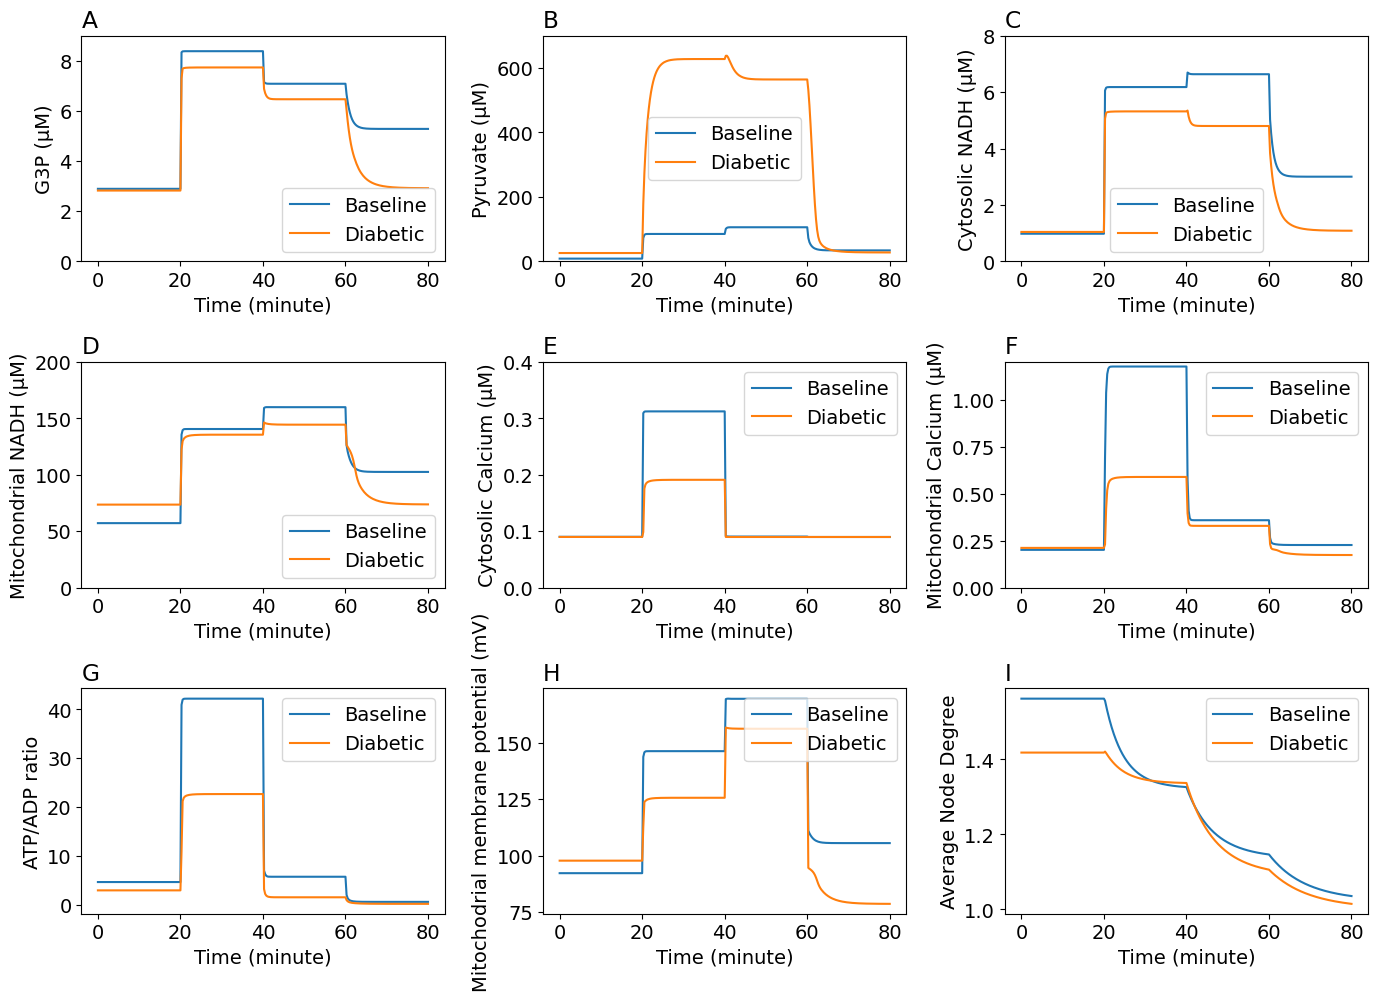

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /builds/NTUMito/wen-wei-tseng/MitochondrialDynamics/.julia/packages/PyCall/L0fLP/src/numpy.jl:67
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


In [6]:
fig71 = plot_fig71(sol, solDM, tend, figsize=(14, 10));

In [7]:
# Uncomment to generate PDF
# fig71.savefig("S1Fig3-1.pdf")

In [8]:
ssalg=DynamicSS(Rodas5(), tspan=tend)

u∞ = solve(SteadyStateProblem(model!, u0, param), ssalg).u
u∞DM = solve(SteadyStateProblem(model!, u0, paramDM), ssalg).u

cbs = CallbackSet( 	PresetTimeCallback([20minute], add_glc!),
                    PresetTimeCallback([40minute], oligomycin!),
                    PresetTimeCallback([60minute], rotenone!))

sol = solve(ODEProblem(model!, u∞, tend, param), callback=cbs)
solDM = solve(ODEProblem(model!, u∞DM, tend, paramDM), callback=cbs);

In [9]:
function plot_fig72(sol, solDM, tend = 80minute;
    figsize=(20,20), lables=["Baseline","Diabetic"], etcCut = 0.05)

    ts = range(0.0, tend, length=301)

    g3p = [sol.(ts, idxs=1) solDM.(ts, idxs=1)]
    pyr = [sol.(ts, idxs=2) solDM.(ts, idxs=2)]
    nadh_c = [sol.(ts, idxs=3) solDM.(ts, idxs=3)]
    nadh_m = [sol.(ts, idxs=4) solDM.(ts, idxs=4)]
    atp_c = [sol.(ts, idxs=5) solDM.(ts, idxs=5)]
    adp_c = [sol.(ts, idxs=6) solDM.(ts, idxs=6)]
    td = atp_c ./ adp_c
    ca_m = [sol.(ts, idxs=7) solDM.(ts, idxs=7)]
    ca_c = cacyto.(adp_c, atp_c, Ref(param), nothing)
    dpsi = [sol.(ts, idxs=8) solDM.(ts, idxs=8)]
    x2 = [sol.(ts, idxs=9) solDM.(ts, idxs=9)]
    x3 = [sol.(ts, idxs=10) solDM.(ts, idxs=10)]
    x1 = getx1.(x2, x3)
    avgDeg = avgdeg.(x2, x3, x1)
    x13 = x1 ./ x3

    jo2 = [param.etc.(nadh_m[:, 1], dpsi[:, 1]) .* 1//10  paramDM.etc.(nadh_m[:, 2], dpsi[:, 2]) .* 1//10]
    jo2[ts .>= 60minute, :] .*= etcCut

    for arr in (g3p, pyr, nadh_c, nadh_m, atp_c, adp_c, ca_m, ca_c, dpsi)
        arr .*= 1000
    end

    ll = lables

    tsm = ts ./ 60

    fig, ax = plt.subplots(3, 3, figsize=figsize)

    ax[1].plot(tsm, jo2)
    ax[1].legend(ll)
    ax[1].set_ylabel("O2 consumption")
    ax[1].set_xlabel("Time (minute)")
    ax[1].set_title("A", loc="left")
    ax[1].set_ylim()

    ax[4].plot(tsm, pyr)
    ax[4].legend(ll)
    ax[4].set_ylabel("Pyruvate (μM)")
    ax[4].set_xlabel("Time (minute)")
    ax[4].set_title("B", loc="left")
    ax[4].set_ylim(0.0, 700.0)

    ax[7].plot(tsm, nadh_c)
    ax[7].legend(ll)
    ax[7].set_ylabel("Cytosolic NADH (μM)")
    ax[7].set_xlabel("Time (minute)")
    ax[7].set_title("C", loc="left")
    ax[7].set_ylim(0.0, 20.0)

    ax[2].plot(tsm, nadh_m)
    ax[2].legend(ll)
    ax[2].set_ylabel("Mitochondrial NADH (μM)")
    ax[2].set_xlabel("Time (minute)")
    ax[2].set_title("D", loc="left")
    ax[2].set_ylim()

    ax[5].plot(tsm, ca_c)
    ax[5].legend(ll)
    ax[5].set_ylabel("Cytosolic Calcium (μM)")
    ax[5].set_xlabel("Time (minute)")
    ax[5].set_title("E", loc="left")
    ax[5].set_ylim(0.0, 0.4)

    ax[8].plot(tsm, ca_m)
    ax[8].legend(ll)
    ax[8].set_ylabel("Mitochondrial Calcium (μM)")
    ax[8].set_xlabel("Time (minute)")
    ax[8].set_title("F", loc="left")
    ax[8].set_ylim(0.0, 1.2)

    ax[3].plot(tsm, td)
    ax[3].legend(ll)
    ax[3].set_ylabel("ATP/ADP ratio")
    ax[3].set_xlabel("Time (minute)")
    ax[3].set_title("G", loc="left")
    ax[3].set_ylim()

    ax[6].plot(tsm, dpsi)
    ax[6].legend(ll, loc="upper right")
    ax[6].set_ylabel("Mitochodrial membrane potential (mV)")
    ax[6].set_xlabel("Time (minute)")
    ax[6].set_title("H", loc="left")
    ax[6].set_ylim()

    ax[9].plot(tsm, avgDeg)
    ax[9].legend(ll)
    ax[9].set_ylabel("Average Node Degree")
    ax[9].set_xlabel("Time (minute)")
    ax[9].set_title("I", loc="left")
    ax[9].set_ylim()
    
    plt.tight_layout()

    return fig
end

plot_fig72 (generic function with 2 methods)

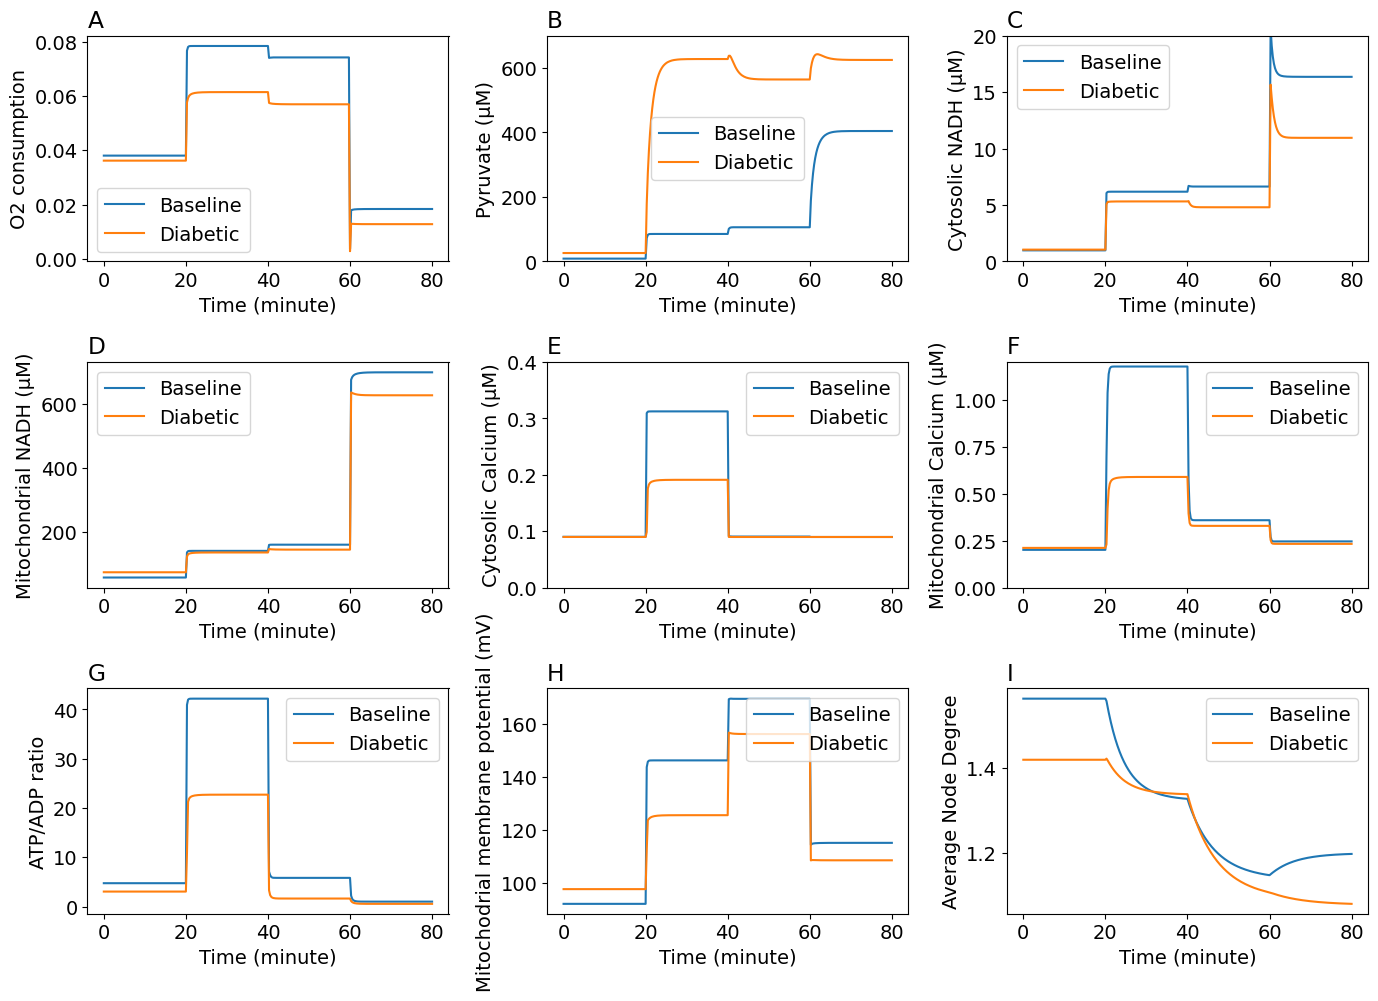

In [10]:
fig72 = plot_fig72(sol, solDM, tend, figsize=(14, 10));

In [11]:
# Uncomment to generate PDF
# fig72.savefig("S1Fig3-2.pdf")